In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
from linear_mcmc import *

from redTools import *
from Kcorrect import *

In [2]:
band2 = 'w2'
inFile = '../reddening/ESN_HI_catal.csv'
scaler, pca = transform(inFile, band1 = 'r', band2 = 'w2')

u = scaler.mean_
s = scaler.scale_
v = scaler.var_
## z = (x-u)/s
##u: mean  s:scale  var=s**2

A = pca.explained_variance_ratio_              # The importance of different PCAs components

pca_inv_data = pca.inverse_transform(np.eye(3)) # coefficients to make PCs from features
p0 = pca_inv_data[0,0]
p1 = pca_inv_data[0,1]
p2 = pca_inv_data[0,2]

print u
print s
print p0, p1, p2

/home/ehsan/PanStarrs/Jan/HI/augment/reddening/redTools.py:55: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  table   = np.genfromtxt(inFile , delimiter=',', filling_values=-1, names=True, dtype=None)


[ 2.46927316  1.62712496 23.34782012]
[0.17962143 1.1468089  1.38279317]
0.524410701848277 0.6008912778745037 -0.6032603815611793


In [3]:
inFile  = 'ESN_HI_catal_calib.csv'
tt   = np.genfromtxt(inFile , delimiter=',', filling_values=-1, names=True, dtype=None)
print len(tt['pgc'])

773


/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  


In [4]:
def RFA_predict(features=['g_r', 'r_i', 'i_z', 'pc0'], out='i', max_depth=2000, n_estimators=2000, \
            min_samples_leaf=15, bootstrap=True):
    
    ## loading data for training the Random Forest algorithm
    inFile = '../reddening/ESN_INC_P0_MAG.csv'
    table_regr = np.genfromtxt(inFile , delimiter=',', filling_values=-1, names=True, dtype=None)


    ################################ Feature selection, regression parameters
#     features = ['g_r', 'r_i', 'i_z', 'pc0']
    output   = out + '_w1'
#     max_depth=2000
#     n_estimators=2000
    max_features=len(features)
#     min_samples_leaf=15
#     bootstrap=True
    ################################ Regression (Random Forest)

    regr_w1 = RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators, \
            max_features=max_features, min_samples_leaf=min_samples_leaf, \
                bootstrap=bootstrap)

    table_all = prepareSamples(table_regr, noTest=True)
    x_all, y_all = ML_data(table_all, features, output)
    regr_w1.fit(x_all, y_all)
    p_y_all_w1  = regr_w1.predict(x_all)
    d = np.abs(p_y_all_w1-y_all)
    tt = 0.6
    indx, = np.where(d<tt)
    X = y_all[indx]
    Xp = p_y_all_w1[indx]
    Y = X-Xp
    m1, b1 = np.polyfit(X,Y, 1)
    
    importances = regr_w1.feature_importances_
    print output, 'Feature Importances: ', importances
    ################################ Feature selection, regression parameters
    output   = out + '_w2'
    regr = RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators, \
            max_features=max_features, min_samples_leaf=min_samples_leaf, \
                bootstrap=bootstrap)
    x_all, y_all = ML_data(table_all, features, output)
    regr.fit(x_all, y_all)
    p_y_all_w2  = regr.predict(x_all)
    d = np.abs(p_y_all_w2-y_all)
    tt = 0.6
    indx, = np.where(d<tt)
    X = y_all[indx]
    Xp = p_y_all_w2[indx]
    Y = X-Xp
    m2, b2 = np.polyfit(X,Y, 1)
    
    importances = regr.feature_importances_
    print output, 'Feature Importances: ', importances
    ################################ Regression (Random Forest)

#     print m1, b1
#     print m2, b2
    return regr_w1, regr, [m1,m2],[b1,b2]

In [5]:
def predict_w1_w2(table, regr_w1, regr, m, b, features, output):
    a = time.time()

    W1_lst = []
    w1p_lst = []
    W2_lst = []
    w2p_lst = []

    for j in range(len(table['pgc'])):
        
        PGC = table['pgc'][j]
        W1  = table['w1'][j]
        W2  = table['w2'][j]
        INC = table["inc"][j]
        M21 = table["m21"][j]
        M0  = table["logWimx"][j]
        WBA = table["Wbap"][j]
        R50 = table["R50_w2p"][j]     
        
        if table['Sqlt'][j]>0:

            def f(w2):
                return predictor(w2, table, regr, features, output, index=j, m=m[1], b=b[1], useFullPredictions=True)
            ###############################################
            out = solver(f, 7, 21, threshold=0.001) 
            if out==None:
                print 'Not solvable ... !!!', PGC
                w2p = 0
                w1p = 0
            else:
                w2p, N = out
                w2p=w2p[0]       
                g_ = table['g0'][j]
                r_ = table['r0'][j]
                i_ = table['i0'][j]
                z_ = table['z0'][j]
                logWimx, c21w, mu50, P0 = get_PC(w2p, M21, M0, WBA, R50)
                g_-=redCorrect(INC, P0, band1='g', band2='w2')
                r_-=redCorrect(INC, P0, band1='r', band2='w2')
                i_-=redCorrect(INC, P0, band1='i', band2='w2')
                z_-=redCorrect(INC, P0, band1='z', band2='w2')
                outDict = {}
                outDict["g_r"] = g_-r_
                outDict["g_i"] = g_-i_
                outDict["g_z"] = g_-z_
                outDict["r_i"] = r_-i_
                outDict["r_z"] = r_-z_
                outDict["i_z"] = i_-z_ 
                
                outDict["pc0"] = P0
                inList=[]
                for f in features: inList.append(outDict[f])
                x_t = np.asarray([inList])
                i_w1p = (regr_w1.predict(x_t)+b[0])/(1.-m[0]) ### regr_w1.predict(x_t)  ### 
                w1p = i_-i_w1p[0]
        else:
            w2p = 0
            w1p = 0
        
        if table['Wqlt'][j]==0:
            W1=0
            W2=0

        W2_lst.append(W2)
        w2p_lst.append(w2p)
        W1_lst.append(W1)
        w1p_lst.append(w1p)    


        ###############################################

    W2_lst = np.asarray(W2_lst)
    w2p_lst = np.asarray(w2p_lst)
    W1_lst = np.asarray(W1_lst)
    w1p_lst = np.asarray(w1p_lst)


    print output, "Time: ", time.time()-a
    return W2_lst, w2p_lst, W1_lst, w1p_lst

In [21]:
inFile = 'ESN_HI_catal_all.csv'

table   = np.genfromtxt(inFile , delimiter=',', filling_values=-1, names=True, dtype=None, encoding=None)
table = extinctionCorrect(table)
table = Kcorrection(table)

# indx = np.asarray(range(650,670))
# table = trim(table, indx)

table['mu50'] = table[band2]+2.5*np.log10(2.*np.pi*(table['R50_'+band2]*60)**2)-2.5*np.log10(table['Wba'])
dWba2 = ((0.1/6./table['R50_'+band2])**2)*(1+table['Wba']**2)
c2 = (2.5/np.log(10))**2
table['Emu50']=np.sqrt(c2*(0.1/6./table['R50_'+band2])**2+c2*dWba2/table['Wba']**2+0.05**2)
table['EC82'] = (5*np.sqrt(2.)/np.log(10))*(0.1/6./table['R50_'+band2])

table['R50_w2p'] = halflight(table["R50_g"], table["R50_r"], table["R50_i"], table["R50_z"])
table['Wbap'] = ba(table["Sba"])

## u0, g0, r0, i0, z0 are already K-/extinction- corrected
table['u0'] = table['u']
table['g0'] = table['g']
table['r0'] = table['r']
table['i0'] = table['i']
table['z0'] = table['z']
table['w10']= table['w1']
table['w20']= table['w2']
table["scaler"] = scaler
table["Cpca"]   = pca

/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in subtract
  # Remove the CWD from sys.path while we load stuff.
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in divide
  # This is added back by InteractiveShellApp.init_path()
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in divide
  del sys.path[0]
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in divide
  


In [23]:
print len(table['pgc'])
print table['pc0']

12773


KeyError: 'pc0'

In [18]:
###################### 0

features=['g_r', 'r_i', 'i_z', 'pc0']

regr_w1, regr, m, b = RFA_predict(features=features, out='g')
W2_lst_g, w2p_lst_g, W1_lst_g, w1p_lst_g = predict_w1_w2(table, regr_w1, regr, m, b, features, 'g_w2')

regr_w1, regr, m, b = RFA_predict(features=features, out='r')
W2_lst_r, w2p_lst_r, W1_lst_r, w1p_lst_r = predict_w1_w2(table, regr_w1, regr, m, b, features, 'r_w2')

regr_w1, regr, m, b = RFA_predict(features=features, out='i')
W2_lst_i, w2p_lst_i, W1_lst_i, w1p_lst_i = predict_w1_w2(table, regr_w1, regr, m, b, features, 'i_w2')

regr_w1, regr, m, b = RFA_predict(features=features, out='z')
W2_lst_z, w2p_lst_z, W1_lst_z, w1p_lst_z = predict_w1_w2(table, regr_w1, regr, m, b, features, 'z_w2')

####################### 1

# features=['r_i', 'i_z', 'pc0']

# regr_w1, regr, m, b = RFA_predict(features=features, out='r')
# W2_lst_r1, w2p_lst_r1, W1_lst_r1, w1p_lst_r1 = predict_w1_w2(table, regr_w1, regr, m, b, features, 'r_w2')

# regr_w1, regr, m, b = RFA_predict(features=features, out='i')
# W2_lst_i1, w2p_lst_i1, W1_lst_i1, w1p_lst_i1 = predict_w1_w2(table, regr_w1, regr, m, b, features, 'i_w2')

# regr_w1, regr, m, b = RFA_predict(features=features, out='z')
# W2_lst_z1, w2p_lst_z1, W1_lst_z1, w1p_lst_z1 = predict_w1_w2(table, regr_w1, regr, m, b, features, 'z_w2')

# ####################### 2

# features=['g_i', 'i_z', 'pc0']

# regr_w1, regr, m, b = RFA_predict(features=features, out='g')
# W2_lst_g2, w2p_lst_g2, W1_lst_g2, w1p_lst_g2 = predict_w1_w2(table, regr_w1, regr, m, b, features, 'g_w2')

# regr_w1, regr, m, b = RFA_predict(features=features, out='i')
# W2_lst_i2, w2p_lst_i2, W1_lst_i2, w1p_lst_i2 = predict_w1_w2(table, regr_w1, regr, m, b, features, 'i_w2')

# regr_w1, regr, m, b = RFA_predict(features=features, out='z')
# W2_lst_z2, w2p_lst_z2, W1_lst_z2, w1p_lst_z2 = predict_w1_w2(table, regr_w1, regr, m, b, features, 'z_w2')

# ####################### 3

# features=['g_r', 'r_z', 'pc0']

# regr_w1, regr, m, b = RFA_predict(features=features, out='g')
# W2_lst_g3, w2p_lst_g3, W1_lst_g3, w1p_lst_g3 = predict_w1_w2(table, regr_w1, regr, m, b, features, 'g_w2')

# regr_w1, regr, m, b = RFA_predict(features=features, out='r')
# W2_lst_r3, w2p_lst_r3, W1_lst_r3, w1p_lst_r3 = predict_w1_w2(table, regr_w1, regr, m, b, features, 'r_w2')

# regr_w1, regr, m, b = RFA_predict(features=features, out='z')
# W2_lst_z3, w2p_lst_z3, W1_lst_z3, w1p_lst_z3 = predict_w1_w2(table, regr_w1, regr, m, b, features, 'z_w2')

# #######################

# features=['pc0']

# regr_w1, regr, m, b = RFA_predict(features=features, out='g')
# W2_lst_g0g, w2p_lst_g0g, W1_lst_g30g, w1p_lst_g30g = predict_w1_w2(table, regr_w1, regr, m, b, features, 'g_w2')

# regr_w1, regr, m, b = RFA_predict(features=features, out='r')
# W2_lst_g0r, w2p_lst_g0r, W1_lst_g30r, w1p_lst_g30r = predict_w1_w2(table, regr_w1, regr, m, b, features, 'r_w2')

# regr_w1, regr, m, b = RFA_predict(features=features, out='i')
# W2_lst_g0i, w2p_lst_g0i, W1_lst_g30i, w1p_lst_g30i = predict_w1_w2(table, regr_w1, regr, m, b, features, 'i_w2')

# regr_w1, regr, m, b = RFA_predict(features=features, out='z')
# W2_lst_g0z, w2p_lst_g0z, W1_lst_g30z, w1p_lst_g30z = predict_w1_w2(table, regr_w1, regr, m, b, features, 'z_w2')

#######################


g_w1 Feature Importances:  [0.5221358  0.01351423 0.01513681 0.44921316]
g_w2 Feature Importances:  [0.11137719 0.01871983 0.03045545 0.83944753]


KeyboardInterrupt: 

In [11]:
W1_lst = W1_lst_i
W2_lst = W2_lst_i

### Averaging over various Random Forest regressors

N = len(W2_lst_i)
w1p_lst = np.zeros(N)
w2p_lst = np.zeros(N)


for j in range(N):
    wp_ = np.zeros(4)
    wp_[0]  = w1p_lst_g[j]
    wp_[1]  = w1p_lst_r[j]
    wp_[2]  = w1p_lst_i[j]
    wp_[3]  = w1p_lst_z[j]
    try:
        indx,   = np.where(wp_!=0)
        if len(indx)>0:
            wp_ = wp_[indx]
            w1p_lst[j] = np.median(wp_)
        else: 
            w1p_lst[j] = W1_lst[j]
    except:
        w1p_lst[j] = W1_lst[j]
        


for j in range(N):
    wp_ = np.zeros(4)
    wp_[0]  = w2p_lst_g[j]
    wp_[1]  = w2p_lst_r[j]
    wp_[2]  = w2p_lst_i[j]
    wp_[3]  = w2p_lst_z[j]
    try:
        indx,   = np.where(wp_!=0)
        if len(indx)>0:
            wp_ = wp_[indx]
            w2p_lst[j] = np.median(wp_)
        else: 
            w2p_lst[j] = W2_lst[j]
    except:
        w2p_lst[j] = W2_lst[j]


In [12]:
N = len(table['pgc'])
gamma_m_u = np.zeros(N)
gamma_p_u = np.zeros(N)
A_m_u = np.zeros(N)
A_p_u = np.zeros(N)

gamma_m_g = np.zeros(N)
gamma_p_g = np.zeros(N)
A_m_g = np.zeros(N)
A_p_g = np.zeros(N)

gamma_m_r = np.zeros(N)
gamma_p_r = np.zeros(N)
A_m_r = np.zeros(N)
A_p_r = np.zeros(N)

gamma_m_i = np.zeros(N)
gamma_p_i = np.zeros(N)
A_m_i = np.zeros(N)
A_p_i = np.zeros(N)

gamma_m_z = np.zeros(N)
gamma_p_z = np.zeros(N)
A_m_z = np.zeros(N)
A_p_z = np.zeros(N)

gamma_m_w1 = np.zeros(N)
gamma_p_w1 = np.zeros(N)
A_m_w1 = np.zeros(N)
A_p_w1 = np.zeros(N)

gamma_m_w2 = np.zeros(N)
gamma_p_w2 = np.zeros(N)
A_m_w2 = np.zeros(N)
A_p_w2 = np.zeros(N)

P0m = np.zeros(N)
P0p = np.zeros(N)

for j in range(N):
    
    w2p  = w2p_lst[j]
    w2m  = W2_lst[j]
    M21  = table["m21"][j]
    M0   = table["logWimx"][j]
    WBA  = table["Wba"][j]
    R50  = table["R50_w2"][j]
    WBAp = table["Wbap"][j]
    R50p = table["R50_w2p"][j]
    INC  = table["inc"][j]
    
    ## MEASURED
    if table["Wqlt"][j]>0:
        logWimx, c21w, mu50, P0  = get_PC(w2m, M21, M0, WBA, R50)
        A_m_u[j],  gamma_m_u[j]  = redCorrect(INC, P0, band1='u', band2='w2', getGamma=True)
        A_m_g[j],  gamma_m_g[j]  = redCorrect(INC, P0, band1='g', band2='w2', getGamma=True)
        A_m_r[j],  gamma_m_r[j]  = redCorrect(INC, P0, band1='r', band2='w2', getGamma=True)
        A_m_i[j],  gamma_m_i[j]  = redCorrect(INC, P0, band1='i', band2='w2', getGamma=True)
        A_m_z[j],  gamma_m_z[j]  = redCorrect(INC, P0, band1='z', band2='w2', getGamma=True)
        A_m_w1[j], gamma_m_w1[j] = redCorrect(INC, P0, band1='w1', band2='w2', getGamma=True)
        A_m_w2[j], gamma_m_w2[j] = redCorrect(INC, P0, band1='w2', band2='w2', getGamma=True)
        P0m[j]=P0
    
    ## PREDICTED
    if table["Sqlt"][j]>0:
        logWimx, c21w, mu50, P0 = get_PC(w2p, M21, M0, WBAp, R50p)
        A_p_u[j],  gamma_p_u[j]  = redCorrect(INC, P0, band1='u', band2='w2', getGamma=True)
        A_p_g[j],  gamma_p_g[j]  = redCorrect(INC, P0, band1='g', band2='w2', getGamma=True)
        A_p_r[j],  gamma_p_r[j]  = redCorrect(INC, P0, band1='r', band2='w2', getGamma=True)
        A_p_i[j],  gamma_p_i[j]  = redCorrect(INC, P0, band1='i', band2='w2', getGamma=True)
        A_p_z[j],  gamma_p_z[j]  = redCorrect(INC, P0, band1='z', band2='w2', getGamma=True)
        A_p_w1[j], gamma_p_w1[j] = redCorrect(INC, P0, band1='w1', band2='w2', getGamma=True)
        A_p_w2[j], gamma_p_w2[j] = redCorrect(INC, P0, band1='w2', band2='w2', getGamma=True)
        P0p[j]=P0

In [13]:
table['pc0'] = P0m
table['pc0p'] = P0p

Ec21w = np.sqrt(table['m21_e']**2+0.05**2)
table['Ec21w'] = Ec21w

w2_best = np.zeros(N)
R50_w2_best = np.zeros(N)
Wba_best = np.zeros(N)
for j in range(N):
    w2_best[j]     = W2_lst[j]
    R50_w2_best[j] = table["R50_w2"][j]
    Wba_best[j]    = table["Wba"][j]
    
    ## Use predicted values for effective radius and surface brightness if ...
    if (table["Wqlt"][j]<3 and table["Sqlt"][j]>1) or (table["Wqlt"][j]==0 and table["Sqlt"][j]>0):
        w2_best[j]     = w2p_lst[j]
        R50_w2_best[j] = table["R50_w2p"][j]
        Wba_best[j]    = table["Wbap"][j]     
        

## Measured - Predicted
c21w = table['m21'] - w2_best
table['c21w'] = c21w

mu50 = w2_best+2.5*np.log10(2.*np.pi*(R50_w2_best*60)**2)-2.5*np.log10(Wba_best)
table['mu50'] = mu50
dWba2 = ((0.1/6./R50_w2_best)**2)*(1+Wba_best**2)
c2 = (2.5/np.log(10))**2
Emu50 = np.sqrt(c2*(0.1/6./R50_w2_best)**2+c2*dWba2/Wba_best**2+0.05**2)
table['Emu50'] = Emu50 


logWimx_e = table['logWimx_e']
table['Epc0'] = np.sqrt((p0*logWimx_e/s[0])**2+(p1*Ec21w/s[1])**2+(p2*Emu50/s[2])**2)




table['u_s']  = table['u']-A_m_u
table['g_s']  = table['g']-A_m_g
table['r_s']  = table['r']-A_m_r
table['i_s']  = table['i']-A_m_i
table['z_s']  = table['z']-A_m_z
table['w1_s'] = table['w1']-A_m_w1
table['w2_s'] = table['w2']-A_m_w2

table['u_ss']  = table['u']-A_p_u
table['g_ss']  = table['g']-A_p_g
table['r_ss']  = table['r']-A_p_r
table['i_ss']  = table['i']-A_p_i
table['z_ss']  = table['z']-A_p_z
table['w1_ss'] = w1p_lst-A_p_w1
table['w2_ss'] = w2p_lst-A_p_w2

In [14]:
### Table modifications .... 

indx, = np.where(table['u000']<0)
table['u000'][indx] = 0
indx, = np.where(table['u']<0)
table['u'][indx] = 0

### NO SDSS data - NO prediction
indx, = np.where(table['Sqlt']==0)
table['u000'][indx]=0
table['g000'][indx]=0
table['r000'][indx]=0
table['i000'][indx]=0
table['z000'][indx]=0
table['u'][indx]=0
table['g'][indx]=0
table['r'][indx]=0
table['i'][indx]=0
table['z'][indx]=0
table['u_s'][indx]=0
table['g_s'][indx]=0
table['r_s'][indx]=0
table['i_s'][indx]=0
table['z_s'][indx]=0
table['u_ss'][indx]=0
table['g_ss'][indx]=0
table['r_ss'][indx]=0
table['i_ss'][indx]=0
table['z_ss'][indx]=0
table['w1_ss'][indx]=table['w1_s'][indx]
table['w2_ss'][indx]=table['w2_s'][indx]
A_p_u[indx]  = A_m_u[indx]
A_p_g[indx]  = A_m_g[indx]
A_p_r[indx]  = A_m_r[indx]
A_p_i[indx]  = A_m_i[indx]
A_p_z[indx]  = A_m_z[indx]
A_p_w1[indx] = A_m_w1[indx]
A_p_w2[indx] = A_m_w2[indx]
gamma_p_u[indx]  = gamma_m_u[indx]
gamma_p_g[indx]  = gamma_m_g[indx]
gamma_p_r[indx]  = gamma_m_r[indx]
gamma_p_i[indx]  = gamma_m_i[indx]
gamma_p_z[indx]  = gamma_m_z[indx]
gamma_p_w1[indx] = gamma_m_w1[indx]
gamma_p_w2[indx] = gamma_m_w2[indx]
w1p_lst[indx] = table['w1'][indx]
w2p_lst[indx] = table['w2'][indx]
table['pc0p'][indx] = table['pc0'][indx]

### NO WISE data
indx, = np.where(table['Wqlt']==0)
table['w1'][indx]=0
table['w2'][indx]=0
table['w1_s'][indx]=0
table['w2_s'][indx]=0
table['pc0'][indx] = table['pc0p'][indx]


indx, = np.where(w2p_lst == 0)
table['pc0p'][indx] = 0

indx, = np.where(W2_lst == 0)
table['pc0'][indx] = 0

## NO prediction 
indx, = np.where(w2p_lst == W2_lst)
table['pc0p'][indx] = table['pc0'][indx]
table['w1_ss'][indx]=table['w1_s'][indx]
table['w2_ss'][indx]=table['w2_s'][indx]
A_p_u[indx]  = A_m_u[indx]
A_p_g[indx]  = A_m_g[indx]
A_p_r[indx]  = A_m_r[indx]
A_p_i[indx]  = A_m_i[indx]
A_p_z[indx]  = A_m_z[indx]
A_p_w1[indx] = A_m_w1[indx]
A_p_w2[indx] = A_m_w2[indx]
gamma_p_u[indx]  = gamma_m_u[indx]
gamma_p_g[indx]  = gamma_m_g[indx]
gamma_p_r[indx]  = gamma_m_r[indx]
gamma_p_i[indx]  = gamma_m_i[indx]
gamma_p_z[indx]  = gamma_m_z[indx]
gamma_p_w1[indx] = gamma_m_w1[indx]
gamma_p_w2[indx] = gamma_m_w2[indx]
w1p_lst[indx] = table['w1'][indx]
w2p_lst[indx] = table['w2'][indx]

In [15]:
myTable = Table()
myTable.add_column(Column(data=table['pgc'], name='pgc'))
myTable.add_column(Column(data=table['Name'], name='Name'))

myTable.add_column(Column(data=table['Vhel'], name='Vhel', format='%0.1f'))
myTable.add_column(Column(data=table['Vls'], name='Vls', format='%0.1f'))

myTable.add_column(Column(data=table['u000'], name='u', format='%0.2f'))
myTable.add_column(Column(data=table['g000'], name='g', format='%0.2f'))
myTable.add_column(Column(data=table['r000'], name='r', format='%0.2f'))
myTable.add_column(Column(data=table['i000'], name='i', format='%0.2f'))
myTable.add_column(Column(data=table['z000'], name='z', format='%0.2f'))
myTable.add_column(Column(data=table['w100'], name='w1', format='%0.2f'))
myTable.add_column(Column(data=table['w200'], name='w2', format='%0.2f'))

myTable.add_column(Column(data=table['u'], name='u_', format='%0.2f'))
myTable.add_column(Column(data=table['g'], name='g_', format='%0.2f'))
myTable.add_column(Column(data=table['r'], name='r_', format='%0.2f'))
myTable.add_column(Column(data=table['i'], name='i_', format='%0.2f'))
myTable.add_column(Column(data=table['z'], name='z_', format='%0.2f'))
myTable.add_column(Column(data=table['w1'], name='w1_', format='%0.2f'))
myTable.add_column(Column(data=table['w2'], name='w2_', format='%0.2f'))

myTable.add_column(Column(data=table['u_s'], name='u*', format='%0.2f'))
myTable.add_column(Column(data=table['g_s'], name='g*', format='%0.2f'))
myTable.add_column(Column(data=table['r_s'], name='r*', format='%0.2f'))
myTable.add_column(Column(data=table['i_s'], name='i*', format='%0.2f'))
myTable.add_column(Column(data=table['z_s'], name='z*', format='%0.2f'))
myTable.add_column(Column(data=table['w1_s'], name='w1*', format='%0.2f'))
myTable.add_column(Column(data=table['w2_s'], name='w2*', format='%0.2f'))

myTable.add_column(Column(data=table['u_ss'], name='u**', format='%0.2f'))
myTable.add_column(Column(data=table['g_ss'], name='g**', format='%0.2f'))
myTable.add_column(Column(data=table['r_ss'], name='r**', format='%0.2f'))
myTable.add_column(Column(data=table['i_ss'], name='i**', format='%0.2f'))
myTable.add_column(Column(data=table['z_ss'], name='z**', format='%0.2f'))
myTable.add_column(Column(data=table['w1_ss'], name='w1**', format='%0.2f'))
myTable.add_column(Column(data=table['w2_ss'], name='w2**', format='%0.2f'))

myTable.add_column(Column(data=W1_lst, name='W1m_', format='%0.2f'))
myTable.add_column(Column(data=W2_lst, name='W2m_', format='%0.2f'))
myTable.add_column(Column(data=w1p_lst, name='W1p_', format='%0.2f'))
myTable.add_column(Column(data=w2p_lst, name='W2p_', format='%0.2f'))

myTable.add_column(Column(data=A_m_u, name='Au', format='%0.2f'))
myTable.add_column(Column(data=A_m_g, name='Ag', format='%0.2f'))
myTable.add_column(Column(data=A_m_r, name='Ar', format='%0.2f'))
myTable.add_column(Column(data=A_m_i, name='Ai', format='%0.2f'))
myTable.add_column(Column(data=A_m_z, name='Az', format='%0.2f'))
myTable.add_column(Column(data=A_m_w1, name='Aw1', format='%0.2f'))
myTable.add_column(Column(data=A_m_w2, name='Aw2', format='%0.2f'))

myTable.add_column(Column(data=gamma_m_u, name='gamma_u', format='%0.2f'))
myTable.add_column(Column(data=gamma_m_g, name='gamma_g', format='%0.2f'))
myTable.add_column(Column(data=gamma_m_r, name='gamma_r', format='%0.2f'))
myTable.add_column(Column(data=gamma_m_i, name='gamma_i', format='%0.2f'))
myTable.add_column(Column(data=gamma_m_z, name='gamma_z', format='%0.2f'))
myTable.add_column(Column(data=gamma_m_w1, name='gamma_w1', format='%0.2f'))
myTable.add_column(Column(data=gamma_m_w2, name='gamma_w2', format='%0.2f'))


myTable.add_column(Column(data=A_p_u, name='A_p_u', format='%0.2f'))
myTable.add_column(Column(data=A_p_g, name='A_p_g', format='%0.2f'))
myTable.add_column(Column(data=A_p_r, name='A_p_r', format='%0.2f'))
myTable.add_column(Column(data=A_p_i, name='A_p_i', format='%0.2f'))
myTable.add_column(Column(data=A_p_z, name='A_p_z', format='%0.2f'))
myTable.add_column(Column(data=A_p_w1, name='A_p_w1', format='%0.2f'))
myTable.add_column(Column(data=A_p_w2, name='A_p_w2', format='%0.2f'))

myTable.add_column(Column(data=gamma_p_u, name='gamma_p_u', format='%0.2f'))
myTable.add_column(Column(data=gamma_p_g, name='gamma_p_g', format='%0.2f'))
myTable.add_column(Column(data=gamma_p_r, name='gamma_p_r', format='%0.2f'))
myTable.add_column(Column(data=gamma_p_i, name='gamma_p_i', format='%0.2f'))
myTable.add_column(Column(data=gamma_p_z, name='gamma_p_z', format='%0.2f'))
myTable.add_column(Column(data=gamma_p_w1, name='gamma_p_w1', format='%0.2f'))
myTable.add_column(Column(data=gamma_p_w2, name='gamma_p_w2', format='%0.2f'))

myTable.add_column(Column(data=table['m21'], name='m21', format='%0.3f'))
myTable.add_column(Column(data=table['m21_e'], name='m21_e', format='%0.3f'))

myTable.add_column(Column(data=table['Wmx'], name='Wmx', format='%0.3f'))
myTable.add_column(Column(data=table['eWmx'], name='eWmx', format='%0.3f'))


myTable.add_column(Column(data=table['logWimx'], name='logWimx', format='%0.3f'))
myTable.add_column(Column(data=table['logWimx_e'], name='logWimx_e', format='%0.3f'))                   
myTable.add_column(Column(data=table['c21w'], name='c21w', format='%0.2f'))
myTable.add_column(Column(data=table['Ec21w'], name='c21w_e', format='%0.2f'))                            
myTable.add_column(Column(data=table['mu50'], name='mu50', format='%0.2f'))
myTable.add_column(Column(data=table['Emu50'], name='mu50_e', format='%0.2f'))                     
myTable.add_column(Column(data=table['pc0'], name='P0', format='%0.2f'))
myTable.add_column(Column(data=table['pc0p'], name='P0p', format='%0.2f'))
myTable.add_column(Column(data=table['Epc0'], name='P0_e', format='%0.2f')) 
myTable.add_column(Column(data=table['inc'], name='inc'))
myTable.add_column(Column(data=table['inc_e'], name='inc_e'))
myTable.add_column(Column(data=R50_w2_best, name='R50', format='%0.2f'))
myTable.add_column(Column(data=Wba_best, name='Wba', format='%0.2f')) 

myTable.add_column(Column(data=table['Sqlt'], name='Sqlt', dtype=np.dtype(int)))
myTable.add_column(Column(data=table['Wqlt'], name='Wqlt', dtype=np.dtype(int)))


myTable.write('corrected_mags_linewidth_all.csv', format='ascii.fixed_width',delimiter='|', bookend=False, overwrite=True) 


In [ ]:
# inFile = '../EDD_distance_cf4_v24.csv'
# table   = np.genfromtxt(inFile , delimiter=',', filling_values=-1, names=True, dtype=None, encoding=None)
# pgc = table['pgc']

cluster = 'NEST_100001.csv'   # Coma
ctl   = np.genfromtxt(cluster , delimiter='|', filling_values=-1, names=True, dtype=None, encoding=None)
PGC = ctl['PGC']

N = len(pgc)
cls=np.zeros(N)
for i in range(len(pgc)):
    id=pgc[i]
    if id in PGC:
        cls[i]=1

myTable = np.genfromtxt('corrected_mags_linewidth.csv' , delimiter=',', filling_values=-1, names=True, dtype=None, encoding=None)
index,  = np.where(cls==1)

### table is a structured array
myTable_ = {}
for name in myTable.dtype.names:
    myTable_[name] = myTable[name]
myTable = myTable_

Coma    = trim(myTable, index)
myTable = Table()
myTable.add_column(Column(data=Coma['pgc'], name='pgc'))
myTable.add_column(Column(data=Coma['Name'], name='Name'))
myTable.add_column(Column(data=Coma['u'], name='u', format='%0.2f'))
myTable.add_column(Column(data=Coma['g'], name='g', format='%0.2f'))
myTable.add_column(Column(data=Coma['r'], name='r', format='%0.2f'))
myTable.add_column(Column(data=Coma['i'], name='i', format='%0.2f'))
myTable.add_column(Column(data=Coma['z'], name='z', format='%0.2f'))
myTable.add_column(Column(data=Coma['w1'], name='w1', format='%0.2f'))
myTable.add_column(Column(data=Coma['w2'], name='w2', format='%0.2f'))
myTable.add_column(Column(data=Coma['logWimx'], name='logWimx', format='%0.3f'))
myTable.add_column(Column(data=Coma['logWimx_e'], name='logWimx_e', format='%0.3f'))                   
myTable.add_column(Column(data=Coma['c21w'], name='c21w', format='%0.2f'))
myTable.add_column(Column(data=Coma['c21w_e'], name='c21w_e', format='%0.2f'))                            
myTable.add_column(Column(data=Coma['mu50'], name='mu50', format='%0.2f'))
myTable.add_column(Column(data=Coma['mu50_e'], name='mu50_e', format='%0.2f'))                     
myTable.add_column(Column(data=Coma['P0'], name='P0', format='%0.2f'))
myTable.add_column(Column(data=Coma['P0_e'], name='P0_e', format='%0.2f')) 
myTable.add_column(Column(data=Coma['inc'], name='inc'))
myTable.add_column(Column(data=Coma['inc_e'], name='inc_e'))
myTable.add_column(Column(data=Coma['Sqlt'], name='Sqlt', dtype=np.dtype(int)))
myTable.add_column(Column(data=Coma['Wqlt'], name='Wqlt', dtype=np.dtype(int)))
myTable.write('NEST_100001_mags_linewidth.csv', format='ascii.fixed_width',delimiter=',', bookend=False, overwrite=True) 


plt.plot(Coma['logWimx'], Coma['i'], 'o')
for i in range(len(pgc)):
    id=pgc[i]
    if id in PGC:
        plt.plot(logWimx[i], table['i'][i]-Ai[i], 'r.')


In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
def plot_array(cluster, clusterName='Coma Cluster', nest='Nest_100001', xLim =(-0.7,0.4), yLim =(19.5,10.5)):
    
#     cluster = 'NEST_100001.csv'   # Coma
    ctl   = np.genfromtxt(cluster , delimiter='|', filling_values=-1, names=True, dtype=None, encoding=None)
    PGC = ctl['PGC']
    
    dye = {"u":"blue","g":"green","r":"red","i":"orange","z":"maroon","w1":"purple", 'w2': "brown"}
    fig = py.figure(figsize=(4, 18), dpi=100) 
    fig.subplots_adjust(wspace=0, top=0.95, bottom=0.15, left=0.05, right=0.98)
    gs = gridspec.GridSpec(7, 1) ; p=0
    
    band_lst = ['u', 'g','r','i','z','w1','w2']
    
    Redden = {}
    eRed   = {}
    Redden['u'] = Au
    Redden['g'] = Ag
    Redden['r'] = Ar
    Redden['i'] = Ai
    Redden['z'] = Az
    Redden['w1'] = Aw1
    Redden['w2'] = Aw1*0.
    eRed['u'] = Au_e
    eRed['g'] = Ag_e
    eRed['r'] = Ar_e
    eRed['i'] = Ai_e
    eRed['z'] = Az_e
    eRed['w1'] = Aw1_e  
    eRed['w2'] = Aw1_e*0.
    
    for band in band_lst:
        
        xlabel = False; ylabel=True
        if band=='w2': xlabel=True
        
        ax = plt.subplot(gs[p]) ; p+=1
        plot_band(ax, PGC, Redden[band], eRed[band], color=dye[band], xlabel=xlabel, ylabel=ylabel, band=band, xLim=xLim, yLim=yLim)
        yticks = ax.yaxis.get_major_ticks()
        if band!='w2': yticks[-1].label1.set_visible(False)
        if band!='w2': plt.setp(ax.get_xticklabels(), visible=False)   
            
        if band=='u': ax.set_title(nest+' ... '+clusterName, fontsize=14)
    
    
    plt.subplots_adjust(hspace=.0, wspace=0)
    
    
def plot_band(ax, PGC, A, eA, color='red', xlabel=True, ylabel=True, X_twin=True, Y_twin=True, band='r', xLim = (1.85,2.9), yLim = (19.5,10.5)):  
    
    pgc       = table['pgc']
    logWimx   = table['logWimx']
    logWimx_e = table['logWimx_e']
    
    mag = table[band] - A
    mag_e = np.sqrt((mag*0.+0.05)**2+eA**2)
    
    pgc_ = []
    logWimx_ = []
    logWimx_e_ = []
    mag_ = []
    mag_e_ = []
    Sqlt_ = []
    Wqlt_ = []
    
    for i in range(len(pgc)):
        id=pgc[i]
        if id in PGC:
            pgc_.append(id)
            logWimx_.append(logWimx[i])
            logWimx_e_.append(logWimx_e[i])
            mag_.append(mag[i])
            mag_e_.append(mag_e[i])
            Sqlt_.append(table['Sqlt'][i])
            Wqlt_.append(table['Wqlt'][i])
    
    pgc_=np.asarray(pgc_)
    logWimx_=np.asarray(logWimx_)
    logWimx_e_=np.asarray(logWimx_e_)
    mag_=np.asarray(mag_)
    mag_e_=np.asarray(mag_e_)
    Sqlt_=np.asarray(Sqlt_)
    Wqlt_=np.asarray(Wqlt_)
    
    
    for i in range(len(pgc_)):
            if Sqlt_[i]>2 and Wqlt_[i]>2:
                ax.errorbar(logWimx_[i], mag_[i], xerr=logWimx_e_[i], yerr=mag_e_[i], fmt='o', color=color, markersize=3)
            else:
                ax.errorbar(logWimx_[i], mag_[i], xerr=logWimx_e_[i], yerr=mag_e_[i], fmt='o', color='k', markersize=3, markerfacecolor='white')

    ax.tick_params(which='major', length=6, width=1.5, direction='in')
    ax.tick_params(which='minor', length=4, color='#000033', width=1.5, direction='in')
    ax.minorticks_on()
    ax.set_xlim(xLim)        
    ax.set_ylim(yLim)
    
    
    indx, = np.where(Sqlt_>2)
    pgc_ = pgc_[indx]
    logWimx_= logWimx_[indx]
    logWimx_e_= logWimx_e_[indx]
    mag_= mag_[indx]
    mag_e_= mag_e_[indx]
    Sqlt_= Sqlt_[indx]
    Wqlt_= Wqlt_[indx]
    

    indx, = np.where(Wqlt_>2)
    pgc_ = pgc_[indx]
    logWimx_= logWimx_[indx]
    logWimx_e_= logWimx_e_[indx]
    mag_= mag_[indx]
    mag_e_= mag_e_[indx]
    Sqlt_= Sqlt_[indx]
    Wqlt_= Wqlt_[indx]
    

#### Linear MCMC fit, considering all errors in both directions
    y_ = np.linspace(5,20,50)
    M,B,samples=linMC1D(mag_, logWimx_-2.5, logWimx_e_, nsteps=1000, ignore=200)
    m = M[0] ; me=0.5*(M[1]+M[2])
    b = B[0] ; be=0.5*(B[1]+B[2])
    m0 = 1./m
    b0 = -b/m
    dm0 = np.abs(me/m**2)
    db0 = np.sqrt((me*b)**2+(be*m)**2)/m**2
    x_, xu, xl = linSimul(samples, y_, size=500)
    ax.fill_betweenx(y_, x_+5*xu+2.50, x_-5*xl+2.50, color='k', alpha=0.2, edgecolor="none")
    ax.plot(m*y_+b+2.5, y_, 'k--') 
    Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
    x0 = 0.9*Xlm[0]+0.1*Xlm[1]
    y0 = 0.15*Ylm[0]+0.85*Ylm[1]
    ax.text(x0,y0, "m= "+"%.2f" % m0+'$\pm$'+"%.2f" % dm0, fontsize=12)
    y0 = 0.30*Ylm[0]+0.70*Ylm[1]
    ax.text(x0,y0, "b= "+"%.2f" % b0+'$\pm$'+"%.2f" % db0, fontsize=12)    
    
    
#     x_ = np.linspace(-5,5,50)
#     M,B,samples=linMC(logWimx_-2.5, mag_, logWimx_e_, mag_e_)
#     m = M[0] ; me=0.5*(M[1]+M[2])
#     b = B[0] ; be=0.5*(B[1]+B[2])
####     y_, yu, yl = linSimul(samples, x_, size=500)
####     ax.fill_between(x_+2.5, y_+5*yu, y_-5*yl, color='k', alpha=0.2, edgecolor="none")
#     ax.plot(x_+2.5, m*x_+b, 'r--')     
#     Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
#     x0 = 0.9*Xlm[0]+0.1*Xlm[1]
#     y0 = 0.22*Ylm[0]+0.78*Ylm[1]
#     ax.text(x0,y0, "m= "+"%.2f" % m+'$\pm$'+"%.2f" % me, fontsize=12, color='red')
#     y0 = 0.40*Ylm[0]+0.60*Ylm[1]
#     ax.text(x0,y0, "b= "+"%.2f" % b+'$\pm$'+"%.2f" % be, fontsize=12, color='red') 

## Traditional one way linear fit    
#     AB, cov  = np.polyfit(mag_,logWimx_-2.5, 1, w=1./logWimx_e_**2, cov=True, full = False)
#     m, b = AB[0],AB[1]
#     me = np.sqrt(cov[0][0])
#     be = np.sqrt(cov[1][1])
#     y = np.linspace(5,20,50)
#     x = m*y+b+2.5
#     ax.plot(x,y, 'b--')  
#     m0 = 1./m
#     b0 = -b/m
#     dm0 = np.abs(me/m**2)
#     db0 = np.sqrt((me*b)**2+(be*m)**2)/m**2
#     Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
#     x0 = 0.9*Xlm[0]+0.1*Xlm[1]
#     y0 = 0.22*Ylm[0]+0.78*Ylm[1]
#     ax.text(x0,y0, "m= "+"%.2f" % m0+'$\pm$'+"%.2f" % dm0, fontsize=12, color='red')
#     y0 = 0.40*Ylm[0]+0.60*Ylm[1]
#     ax.text(x0,y0, "b= "+"%.2f" % b0+'$\pm$'+"%.2f" % db0, fontsize=12, color='red')     
    

    
    ### PCA analysis to fit the best line
#     X = logWimx_
#     Y = mag_
#     scaler = StandardScaler()
#     data = {'X':X, 'Y':Y}
#     order_of_keys = ['X','Y']
#     list_of_tuples = [(key, data[key]) for key in order_of_keys]
#     data = OrderedDict(list_of_tuples)
#     n_comp = len(data)
#     d =  pd.DataFrame.from_dict(data) 
#     z_data = scaler.fit_transform(d)
#     pca = PCA().fit(z_data)
#     u = scaler.mean_ ; ux=u[0]; uy=u[1]
#     s = scaler.scale_ ; sx=s[0]; sy=s[1]
#     x_ = np.linspace(1,4,50)
#     pca_inv_data = pca.inverse_transform(np.eye(n_comp))
#     px = pca_inv_data[0,0]
#     py = pca_inv_data[0,1]
#     y_ = (py*sy*(x_-ux))/px/sx+uy
#     ax.plot(x_, y_, 'r-') 
    
   
    if ylabel: 
        if band!='w1':
            ax.set_ylabel(r'$'+band+'^*$', fontsize=18) 
        else:
            ax.set_ylabel(r'$W1^*$', fontsize=18)
    
    if xlabel:
        ax.set_xlabel(r'$Log( W_{mx}^i)$', fontsize=18) 
    
    if True:
        y_ax = ax.twinx()
        y_ax.set_ylim(yLim)
        y_ax.set_yticklabels([])
        y_ax.minorticks_on()
        y_ax.tick_params(which='major', length=6, width=1.5, direction='in')
        y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')        
    
    if True:
        x_ax = ax.twiny()
        x_ax.set_xlim(xLim)
        x_ax.set_xticklabels([])
        x_ax.minorticks_on()
        x_ax.tick_params(which='major', length=6, width=1.5, direction='in')
        x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')     

        
    for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
    for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
    
    print len(pgc_)
    

75
75
75
75
75
75
75


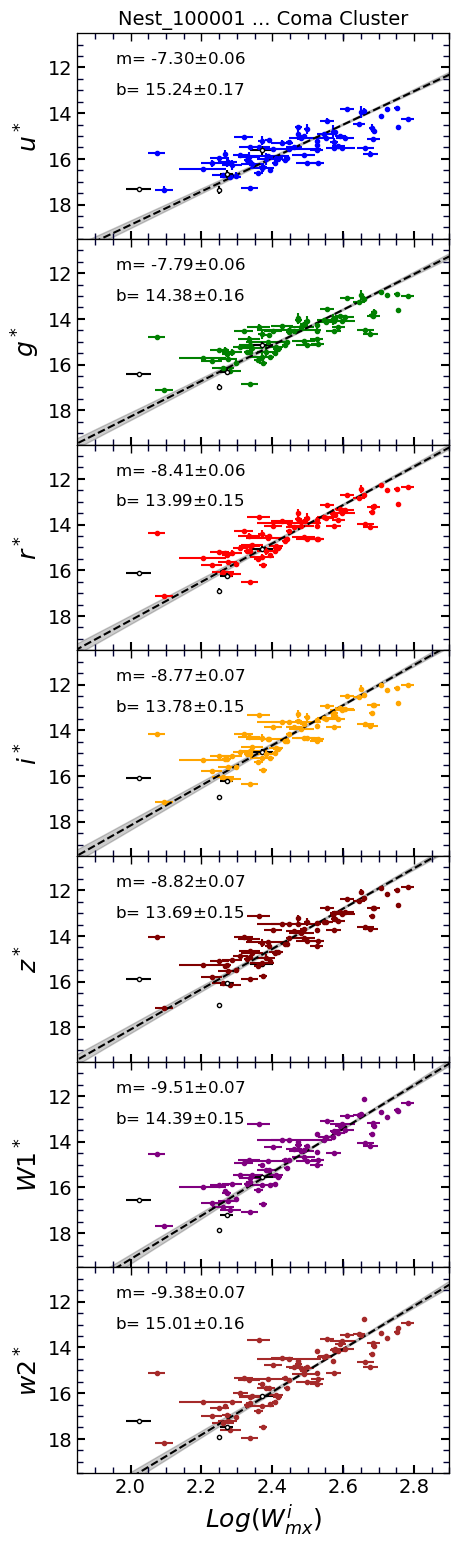

In [7]:
plot_array('NEST_100001.csv', clusterName='Coma Cluster', nest='Nest_100001', xLim = (1.85,2.9), yLim = (19.5,10.5))

100
100
100
100
100
100
100


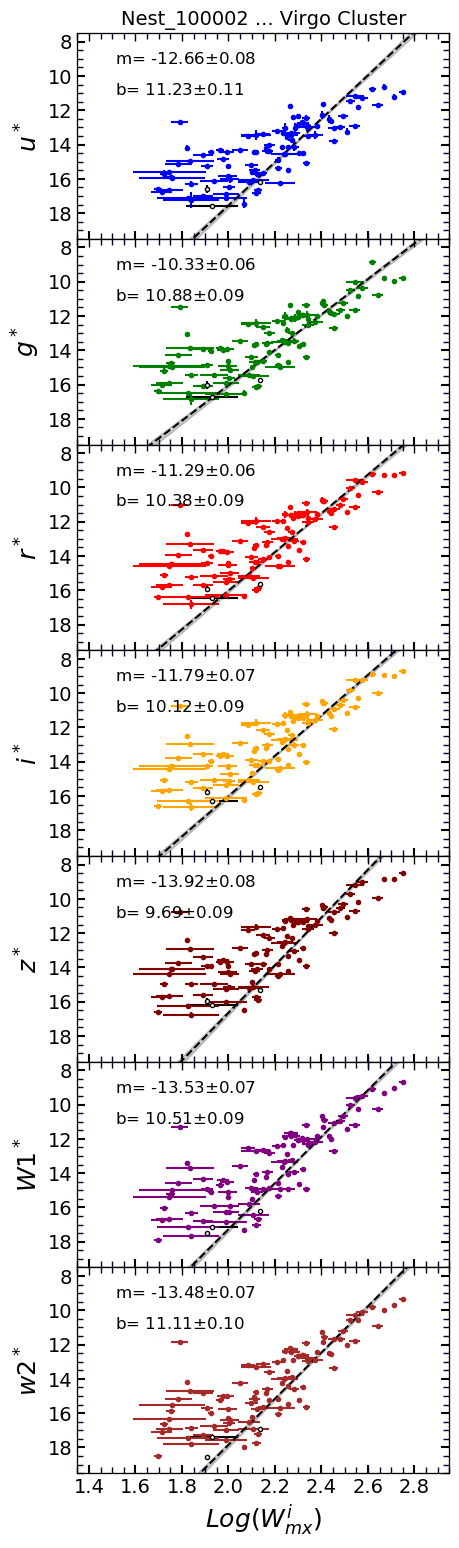

In [8]:
plot_array('NEST_100002.csv', clusterName='Virgo Cluster', nest='Nest_100002', xLim = (1.35,2.95), yLim = (19.5,7.5))

66
66
66
66
66
66
66


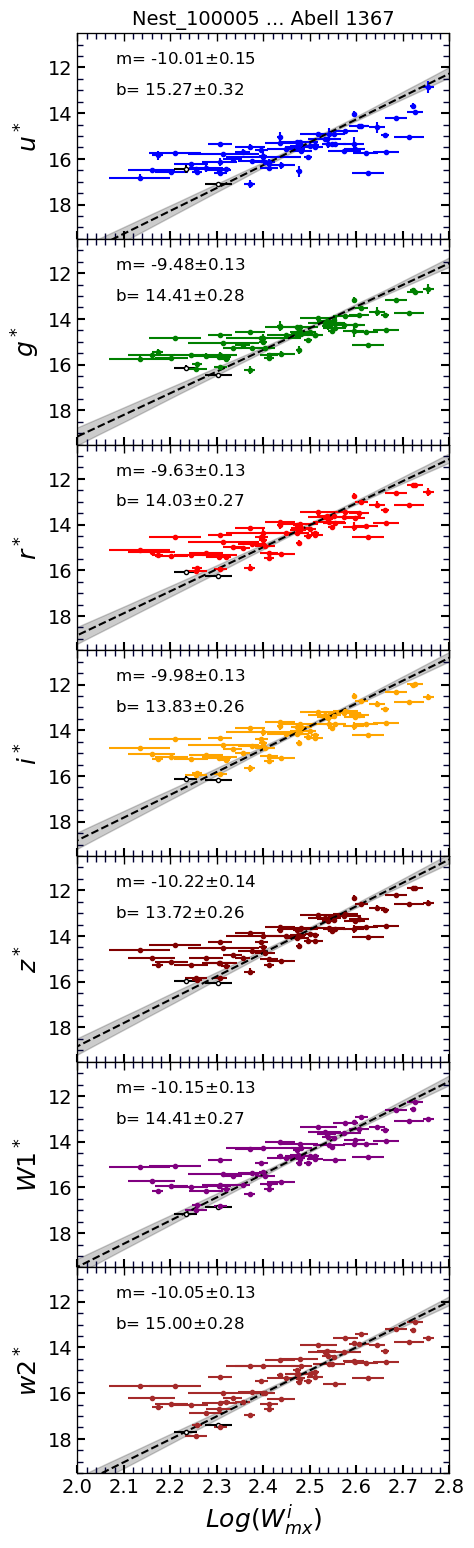

In [9]:
plot_array('NEST_100005.csv', clusterName='Abell 1367', nest='Nest_100005', xLim = (2,2.8), yLim = (19.5,10.5))

31
31
31
31
31
31
31


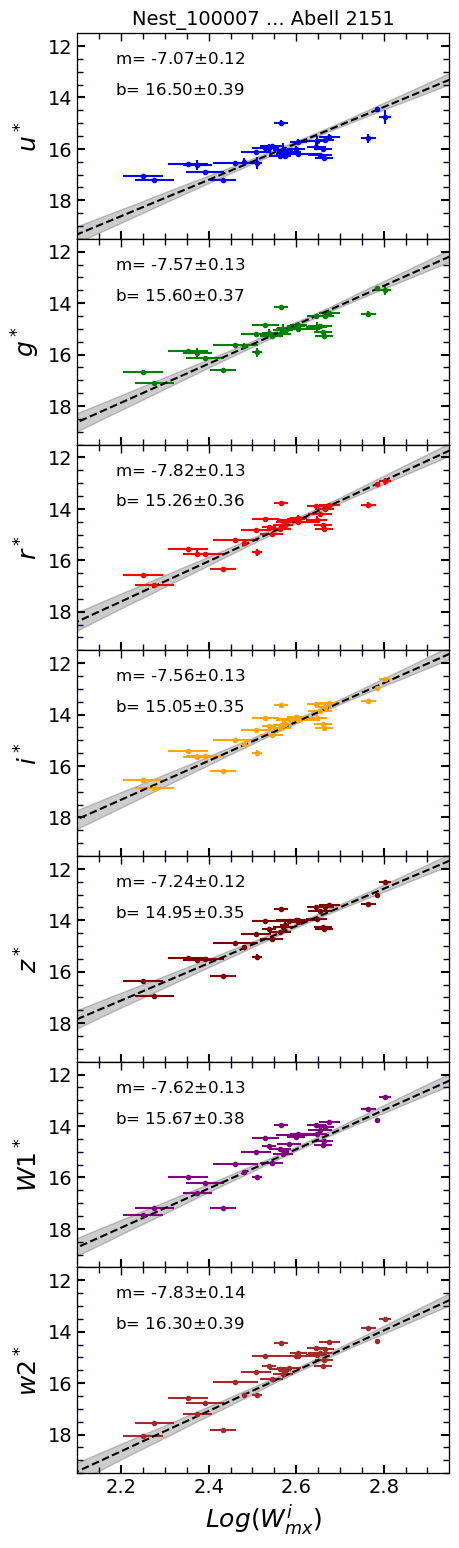

In [10]:
plot_array('NEST_100007.csv', clusterName='Abell 2151', nest='Nest_100007', xLim = (2.1,2.95), yLim = (19.5,11.5))

36
36
36
36
36
36
36


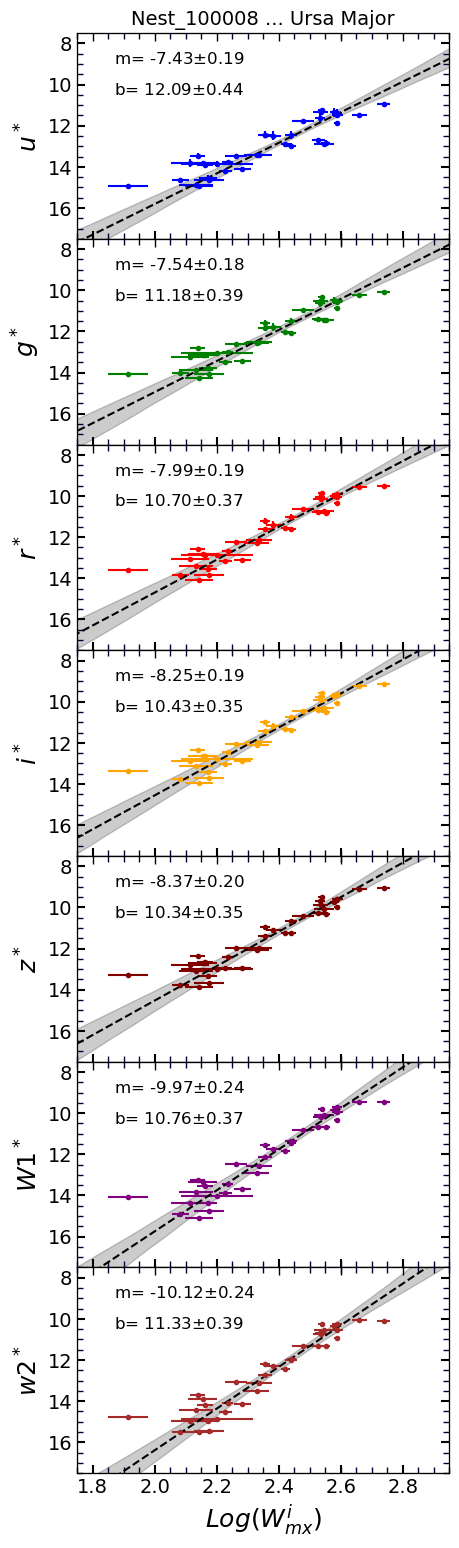

In [11]:
plot_array('NEST_100008.csv', clusterName='Ursa Major', nest='Nest_100008', xLim = (1.75,2.95), yLim = (17.5,7.5))

11
11
11
11
11
11
11


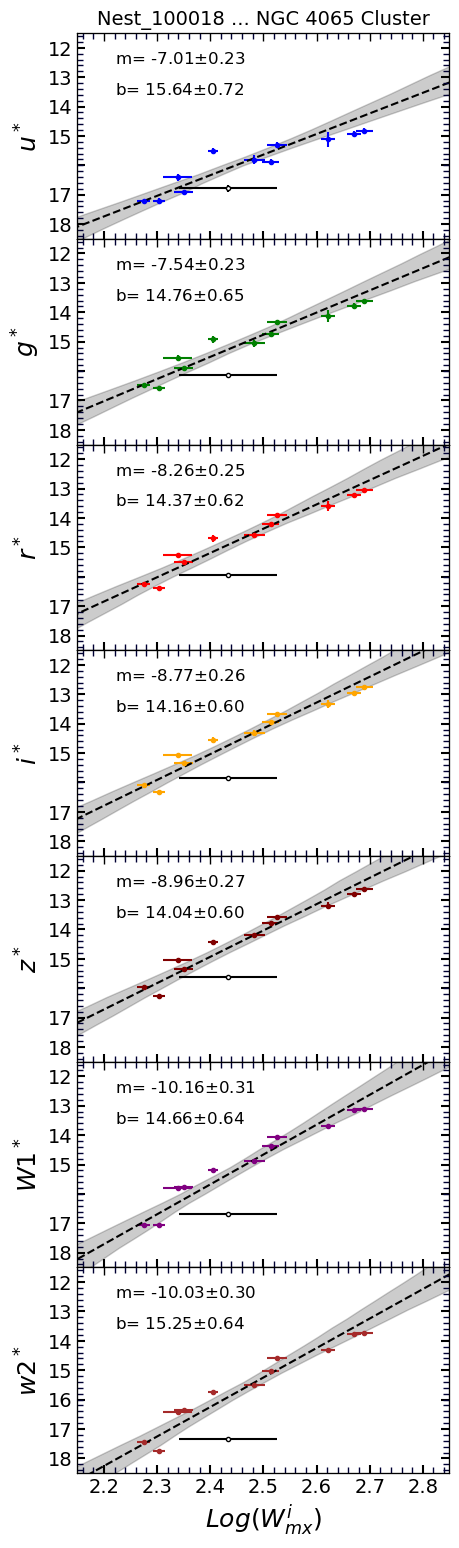

In [12]:
plot_array('NEST_100018.csv', clusterName='NGC 4065 Cluster', nest='Nest_100018', xLim = (2.15,2.85), yLim = (18.5,11.5))

18
18
18
18
18
18
18


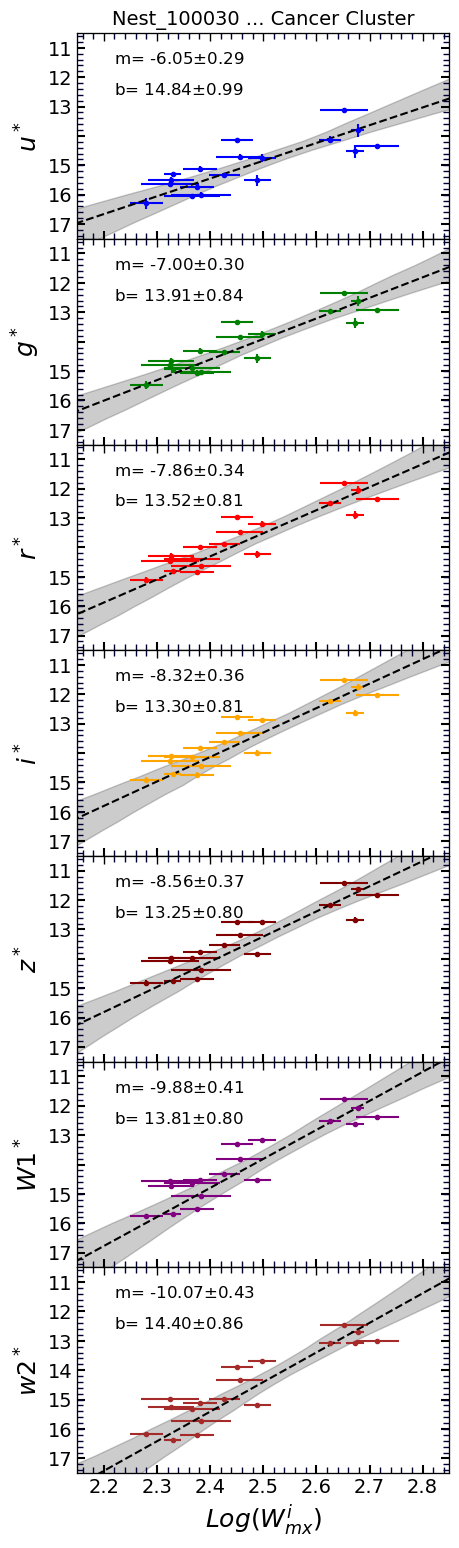

In [13]:
plot_array('NEST_100030.csv', clusterName='Cancer Cluster', nest='Nest_100030', xLim = (2.15,2.85), yLim = (17.5,10.5))

15
15
15
15
15
15
15


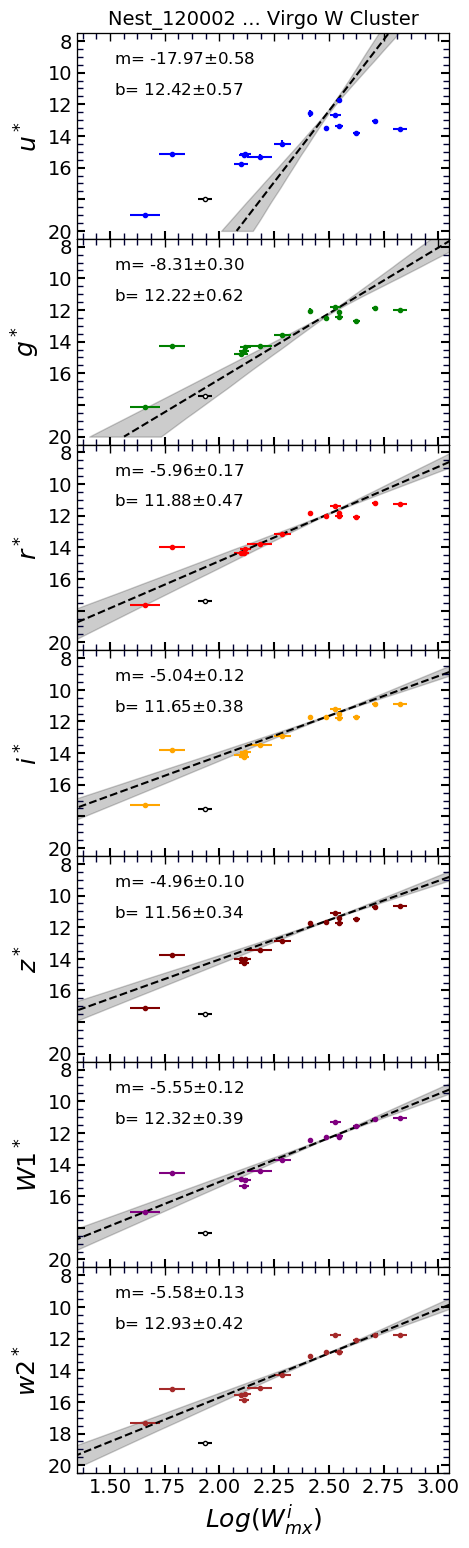

In [14]:
plot_array('NEST_120002.csv', clusterName='Virgo W Cluster', nest='Nest_120002', xLim = (1.35,3.05), yLim = (20.5,7.5))

6
6
6
6
6
6
6


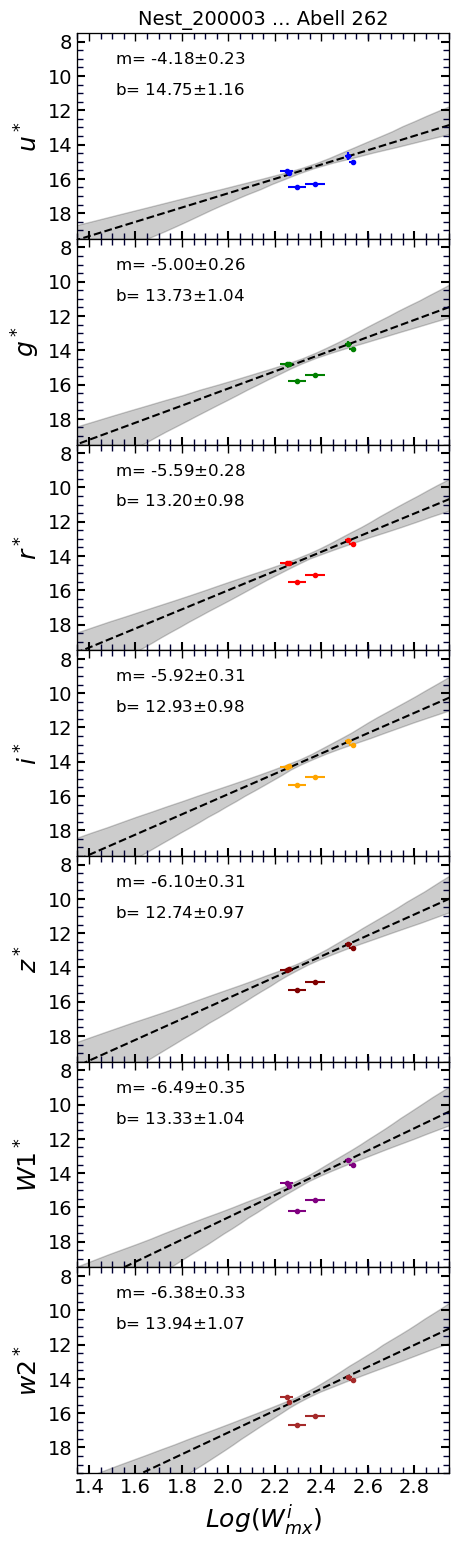

In [15]:
plot_array('NEST_200003.csv', clusterName='Abell 262', nest='Nest_200003', xLim = (1.35,2.95), yLim = (19.5,7.5))

33
33
33
33
33
33
33


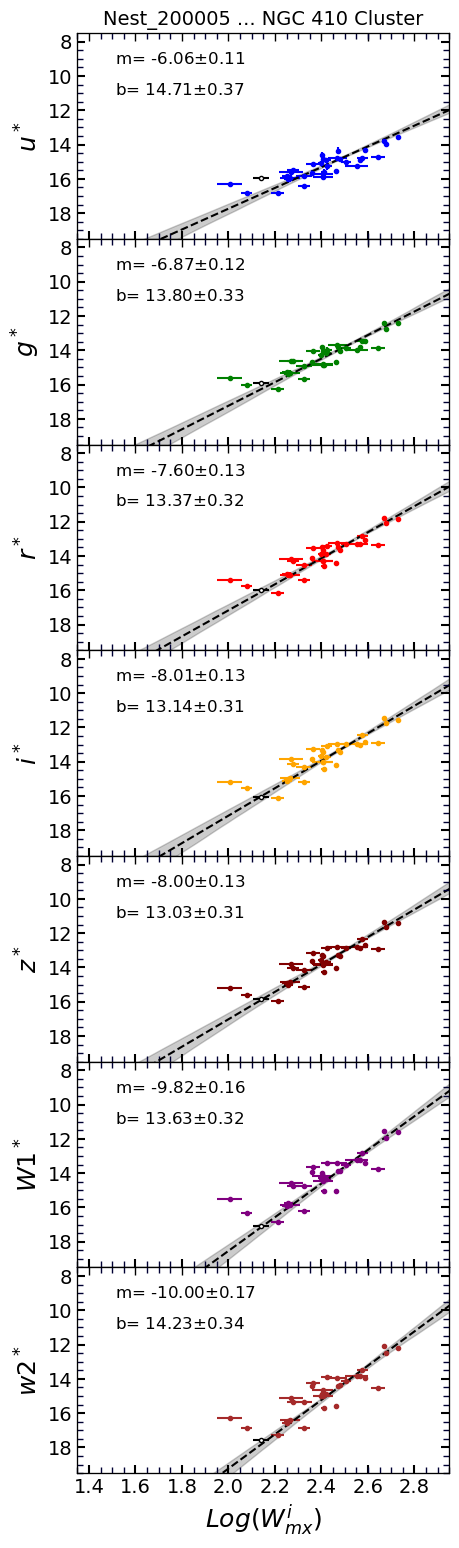

In [16]:
plot_array('NEST_200005.csv', clusterName='NGC 410 Cluster', nest='Nest_200005', xLim = (1.35,2.95), yLim = (19.5,7.5))

33
33
33
33
33
33
33


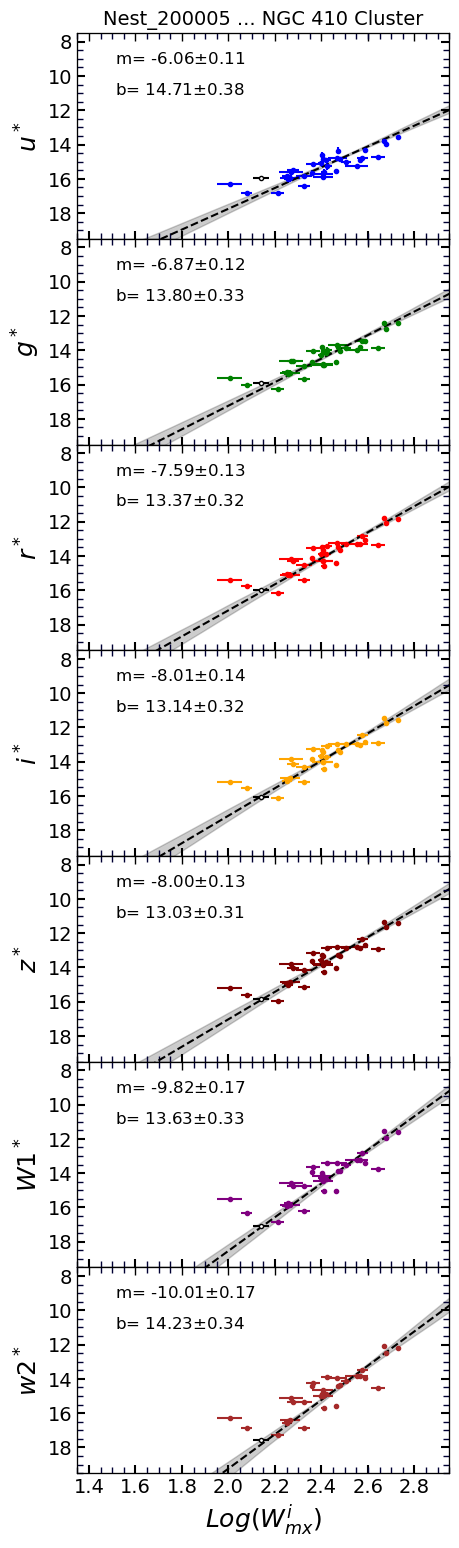

In [17]:
plot_array('NEST_200005.csv', clusterName='NGC 410 Cluster', nest='Nest_200005', xLim = (1.35,2.95), yLim = (19.5,7.5))